In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score, make_scorer, accuracy_score
from xgboost import XGBClassifier
import ipywidgets as widgets
from IPython.display import display, clear_output
import joblib
from flask import Flask, request, jsonify

In [40]:
def load_data(file_path):
    """Load CSV data into a pandas DataFrame."""
    df = pd.read_csv(file_path, sep = ';')
    return df

def eda_overview(df, target='y', name="Dataset"):
    """Perform an exploratory data analysis summary of the DataFrame."""
    print(f"--- EDA Summary for {name} ---")
    
    print(f"Shape: {df.shape}\n")
    print("Data types:\n", df.dtypes, "\n")
    print("First 5 rows:\n", df.head(), "\n")
    print("Missing values per column:\n", df.isnull().sum(), "\n")
    
    if target in df.columns:
        print(f"Target variable '{target}' distribution:\n", df[target].value_counts(normalize=True), "\n")
    
    print("Summary statistics:\n", df.describe(include='all'), "\n")
    
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    print("Unique values per categorical column:")
    for col in categorical_cols:
        print(f"{col}: {df[col].unique()}")
    print("\n")
    
    numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
    corr = df[numeric_cols].corr()
    plt.figure(figsize=(10,7))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title(f"Correlation heatmap for {name}")
    plt.show()
    
    for col in numeric_cols:
        plt.figure(figsize=(6,3))
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot of {col} in {name}")
        plt.show()

def preprocess_data(df):
    """Preprocess the dataset by encoding, feature engineering, and handling outliers."""
    # Encode target variable
    df['y'] = df['y'].map({'no': 0, 'yes': 1})

    # Feature: contacted_before based on 'pdays'
    df['contacted_before'] = np.where(df['pdays'] == 999, 0, 1)

    # Map month to numeric
    month_map = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6,
                 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
    df['month_num'] = df['month'].map(month_map)

    # Quarterly bins
    df['quarter'] = pd.cut(df['month_num'], bins=[0,3,6,9,12], labels=['Q1','Q2','Q3','Q4'])

    # Remove outliers for specified columns using IQR method
    def remove_outliers_iqr(df, col):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        filtered_df = df[(df[col] >= lower) & (df[col] <= upper)]
        print(f"Removed {len(df) - len(filtered_df)} outliers from '{col}'")
        return filtered_df

    for col in ['duration', 'campaign']:
        df = remove_outliers_iqr(df, col)

    # New feature: campaign intensity relative to previous contacts
    df['campaign_vs_previous'] = df['campaign'] / (df['previous'] + 1)

    # Duration category bins
    duration_bins = [0, 60, 180, np.inf]
    duration_labels = ['short', 'medium', 'long']
    df['duration_category'] = pd.cut(df['duration'], bins=duration_bins, labels=duration_labels)

    # Encode quarters as integer
    df['quarter'] = pd.to_datetime(df['month_num'], format='%m').dt.quarter

    # One-hot encode categorical features (including engineered duration_category)
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    df = pd.get_dummies(df, columns=['duration_category'] + categorical_cols, drop_first=True)

    return df

def encode_features(df, target_col='y'):
    """Separate features and target, and label encode any remaining object columns."""
    X = df.drop(columns=target_col)
    y = df[target_col]

    for col in X.select_dtypes(include='object').columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
    
    return X, y
    
def split_data(X, y, test_size=0.2, random_state=42):
    """
    Split features and target into train and test sets with stratification.

    Parameters:
    - X: Feature matrix
    - y: Target vector
    - test_size: Proportion of data for test set
    - random_state: Seed for reproducibility

    Returns:
    - X_train, X_test, y_train, y_test
    """
    return train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )


def get_scale_pos_weight(y):
    """Calculate scale_pos_weight for imbalance handling in XGBoost."""
    neg = sum(y == 0)
    pos = sum(y == 1)
    return neg / pos

def tune_xgboost(X_train, y_train):
    """Perform GridSearchCV to tune XGBoost hyperparameters with multiple scoring metrics."""
    scale_pos_weight = get_scale_pos_weight(y_train)

    xgb = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight,
        random_state=42
    )

    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200],
        'subsample': [0.8, 1],
        'colsample_bytree': [0.8, 1]
    }

    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score),
        'roc_auc': 'roc_auc'
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring=scoring,
        refit='roc_auc',
        cv=cv,
        verbose=1,
        n_jobs=-1,
        return_train_score=True
    )

    grid_search.fit(X_train, y_train)

    print("Best parameters found:", grid_search.best_params_)
    print("Best ROC AUC:", grid_search.best_score_)

    return grid_search.best_estimator_

def show_xgboost_feature_importance(model, X_test, y_test):
    """Display feature importances from the trained XGBoost model."""
    print("\nXGBoost Feature Importances (Gain):")
    importance_df = pd.DataFrame({
        'Feature': model.get_booster().feature_names,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    print(importance_df.head(10))

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='viridis')
    plt.title("Top 15 Feature Importances (Gain) - XGBoost")
    plt.tight_layout()
    plt.show()

    # Permutation importance
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    perm_df = pd.DataFrame({
        'Feature': X_test.columns,
        'Importance': perm_importance.importances_mean
    }).sort_values(by='Importance', ascending=False)

    print("\nPermutation Importances (Test Set):")
    print(perm_df.head(10))

    plt.figure(figsize=(10, 6))
    sns.barplot(data=perm_df.head(15), x='Importance', y='Feature', palette='coolwarm')
    plt.title("Top 15 Permutation Importances - XGBoost")
    plt.tight_layout()
    plt.show()


def evaluate_model(model, X_test, y_test):
    """Evaluate the model performance on the test set."""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

    return y_test, y_proba

def interactive_threshold_metrics(y_test, y_proba):
    """Create an interactive slider to adjust classification threshold and show metrics."""

    def update_threshold(threshold):
        y_pred = (y_proba >= threshold).astype(int)

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        clear_output(wait=True)
        print(f"Threshold: {threshold:.2f}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall:    {recall:.3f}")
        print(f"F1 Score:  {f1:.3f}")

        labels = ['Precision', 'Recall', 'F1 Score']
        values = [precision, recall, f1]

        plt.figure(figsize=(6, 4))
        bars = plt.bar(labels, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
        plt.ylim(0, 1)
        plt.title(f'Model Metrics at Threshold = {threshold:.2f}')
        plt.axhline(0.5, linestyle='--', color='gray', linewidth=1)

        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.02, f'{yval:.2f}', ha='center')

        plt.tight_layout()
        plt.show()

    threshold_slider = widgets.FloatSlider(
        value=0.5,
        min=0.0,
        max=1.0,
        step=0.01,
        description='Threshold:',
        continuous_update=False
    )

    widgets.interact(update_threshold, threshold=threshold_slider)


In [41]:
# -------------workflow ----------------

#Load data
df_additional = load_data("C:/Users/User/Desktop/data 1 (4) (1)/data/bank-additional-full.csv")
df_additional

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


--- EDA Summary for bank-additional-full.csv ---
Shape: (41188, 21)

Data types:
 age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object 

First 5 rows:
    age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.

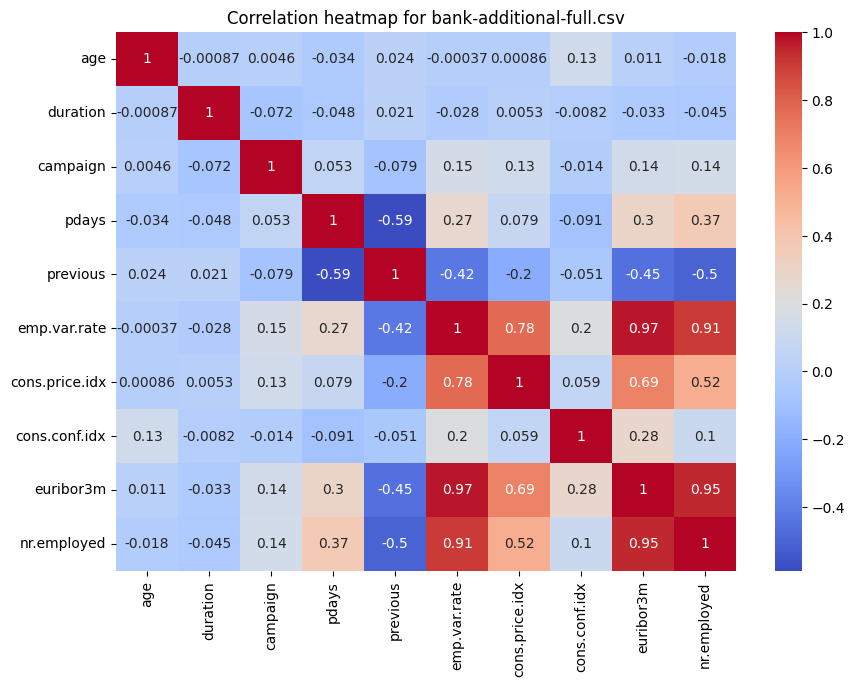

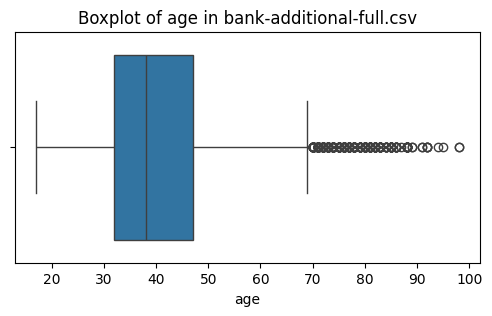

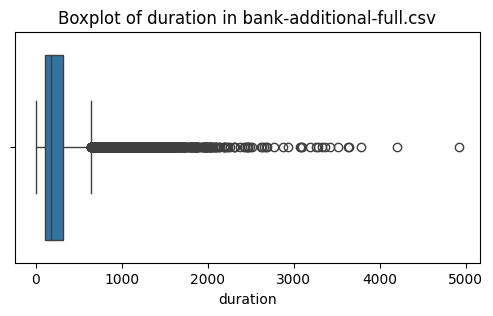

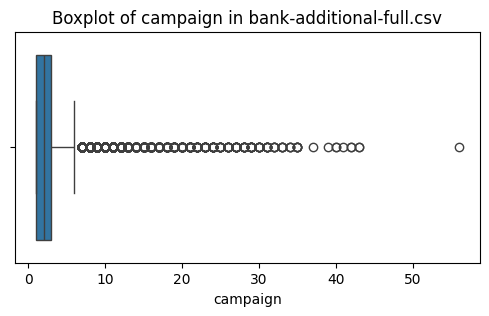

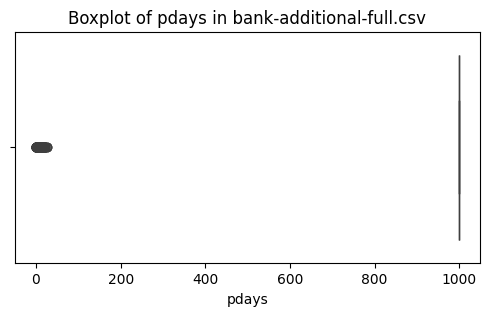

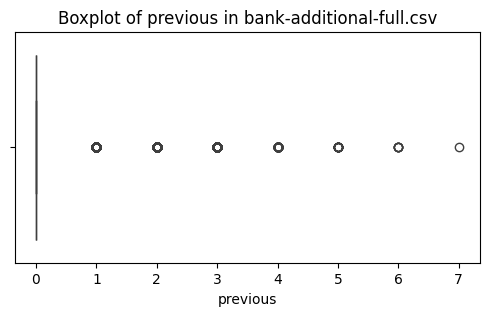

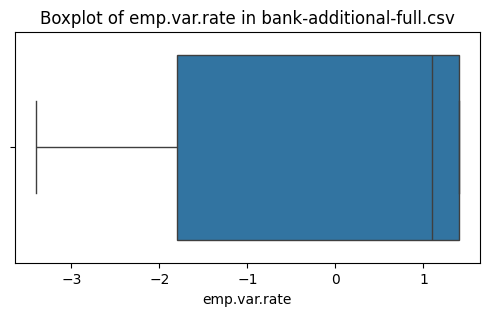

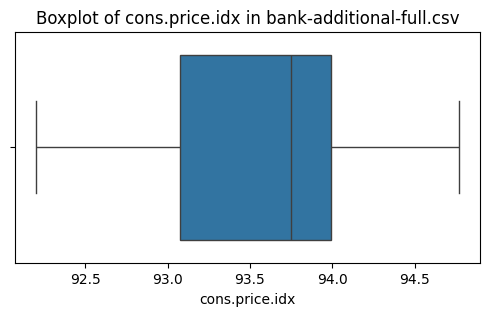

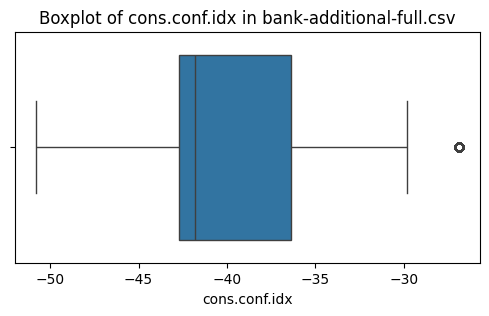

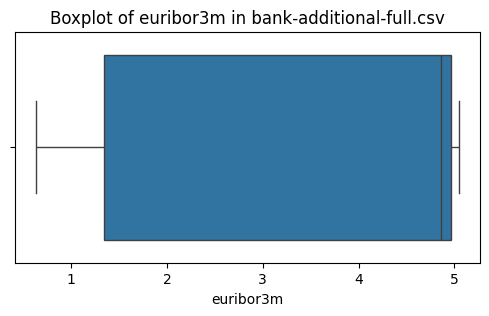

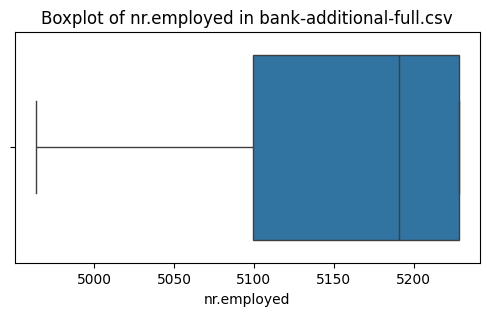

In [20]:
# EDA
eda_overview(df_additional, name="bank-additional-full.csv")

In [21]:
# Preprocessing
df_processed = preprocess_data(df_additional)

Removed 2963 outliers from 'duration'
Removed 2262 outliers from 'campaign'


In [22]:
# Or encode all features with label encoding if preferred
X, y = encode_features(df_processed)

In [39]:
# Save the final column names
joblib.dump(X.columns.tolist(), "model_columns.pkl")

['model_columns.pkl']

In [23]:
# Train Random Forest (optional)
X_train, X_test, y_train, y_test = split_data(X, y)

In [24]:
# Tune XGBoost with Grid Search
xgb_best = tune_xgboost(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Users\User\.conda\envs\creating_an_environment\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:02:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best ROC AUC: 0.9551729354542576



XGBoost Feature Importances (Gain):
              Feature  Importance
5        emp.var.rate    0.342740
9         nr.employed    0.147581
51          month_oct    0.105465
1            duration    0.034793
49          month_may    0.021889
8           euribor3m    0.019725
7       cons.conf.idx    0.019678
43  contact_telephone    0.015779
16    job_blue-collar    0.014755
3               pdays    0.014737


C:\Users\User\AppData\Local\Temp\ipykernel_35272\1423844724.py:178: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='viridis')


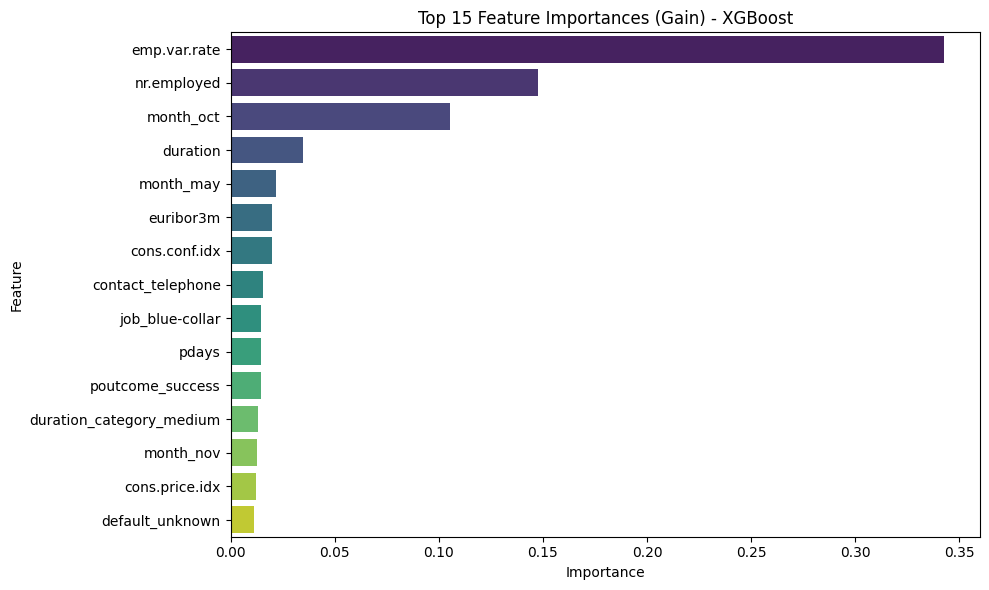


Permutation Importances (Test Set):
            Feature  Importance
1          duration    0.043334
5      emp.var.rate    0.038232
8         euribor3m    0.020228
51        month_oct    0.003211
4          previous    0.002878
56  day_of_week_wed    0.001501
53  day_of_week_mon    0.001376
0               age    0.001237
2          campaign    0.001112
16  job_blue-collar    0.001112


C:\Users\User\AppData\Local\Temp\ipykernel_35272\1423844724.py:194: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perm_df.head(15), x='Importance', y='Feature', palette='coolwarm')


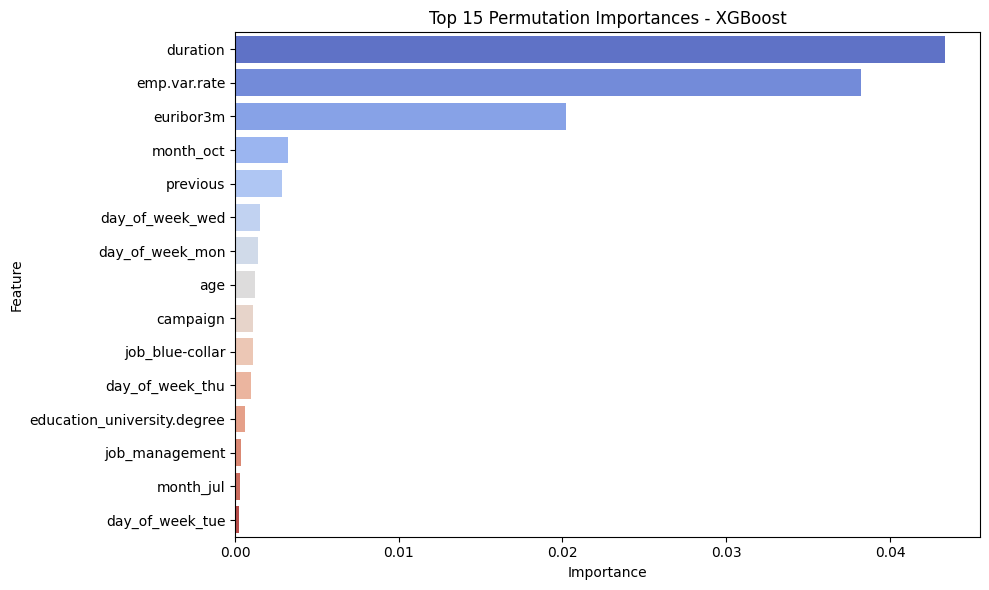

In [26]:
# Visualize feature importances
show_xgboost_feature_importance(xgb_best, X_test, y_test)

In [27]:
# Evaluate best XGBoost model
y_test, y_proba = evaluate_model(xgb_best, X_test, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      6579
           1       0.40      0.90      0.56       614

    accuracy                           0.88      7193
   macro avg       0.70      0.89      0.74      7193
weighted avg       0.94      0.88      0.90      7193

ROC AUC Score: 0.9529


In [28]:
# Launch interactive threshold metrics widget
interactive_threshold_metrics(y_test, y_proba)

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='Threshold:', max=1.0, step=…

# Findings and Insights
Exploratory Data Analysis (EDA) Findings
Data Overview: After splitting the Excel data into proper columns, the bank-additional-full.csv dataset consisted of 41,188 rows and 21 features. No missing values were detected.

Target Distribution: Only 7.3% of customers subscribed (y = yes) to the term deposit, indicating a strong class imbalance.

Correlations:

The most correlated numeric variables with the target (y) included duration, emp.var.rate, euribor3m, and nr.employed.

duration showed a positive correlation with subscription, although it is only known after the call—thus it was kept mainly for exploratory purposes and feature analysis, not for pre-call predictions.

Feature Importance Insights (XGBoost Model)
From both gain-based and permutation-based importances:

Top Predictive Features:

emp.var.rate, nr.employed, euribor3m, and cons.conf.idx — all economic indicators — were highly predictive of subscription.

duration, though predictive, is post-call and may not be useful for early targeting but helps understand effectiveness.

Certain months (month_oct, month_may) and job types (job_blue-collar) also influenced outcomes.

These insights suggest that macroeconomic sentiment and timing heavily influence client decisions to subscribe.

Model Performance and Trade-offs
ROC AUC: 0.955, indicating strong discriminatory power.

Precision (class 1): 0.40 → only 40% of predicted subscribers were actual subscribers.

Recall (class 1): 0.90 → 90% of actual subscribers were correctly identified.

Trade-off between Precision and Recall:

In this case, recall is prioritized to ensure most interested clients are contacted.

A lower precision is acceptable as it results in some extra calls, but missing a truly interested client is more costly than contacting an uninterested one.

📌 This means the model is optimized to capture as many potential subscribers as possible, even if it means false positives—perfect for maximizing campaign reach, because missing an interested client means the loss of more money than contacting an uninterested client.

Actionable Recommendations for Marketing
Target based on economic conditions: Launch campaigns during favorable employment and interest rate conditions (emp.var.rate, euribor3m, etc.).

Prioritize follow-ups with clients previously contacted (contacted_before) or those contacted in months like October and May.

Job roles matter: Clients in blue-collar jobs are less likely to subscribe—may need alternative scripts or incentives.

Customize contact strategy: Use predicted probabilities to tier clients (e.g., high probability = personal call; medium = email/SMS).

In [31]:
joblib.dump(xgb_best, 'xgb_model.pkl')

['xgb_model.pkl']